# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download neste link: https://drive.google.com/drive/u/1/folders/1G6hrzbcx3KlUHLIrmLVjyQCtFwRW_azx

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

## Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

## Consolidar Base de Dados

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = Path('dataset')

bases = []

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    bases.append(df)

base_airbnb = pd.concat(bases)
display(base_airbnb)

C:\Users\gabri\AppData\Local\Temp\ipykernel_8920\1869834279.py:14: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_8920\1869834279.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_8920\1869834279.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_8920\1869834279.py:14: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_8920\1869834279.py:14: DtypeWarning: Columns (61,62,94) have mixed types.

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas
colunas da nossa base
- Tipos de colunas que vamos excluir:
    
    1. IDs, links e informações não relevantes para o modelo. 
    2. Colunas repetidas ou extremamente parecidas com outras (que dão a mesma informação para o modelo) Ex: Data x Ano/Mês.
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo.
    4. Coluna em que todos ou quase todos valores são iguais.
    
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa

In [3]:
#base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

## Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb[colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

## Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram
excluídas da análise.

- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN.

In [5]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [6]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


## Verificar Tipos de Dados em cada coluna

In [7]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como price e extra_people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [8]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$','')
base_airbnb['price'] = base_airbnb['price'].str.replace(',','')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


## Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, **valores abaixo de Q1 - 1.5 x Amplitude** & **valores acima de Q3 + 1.5 x Amplitude**). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<Axes: >

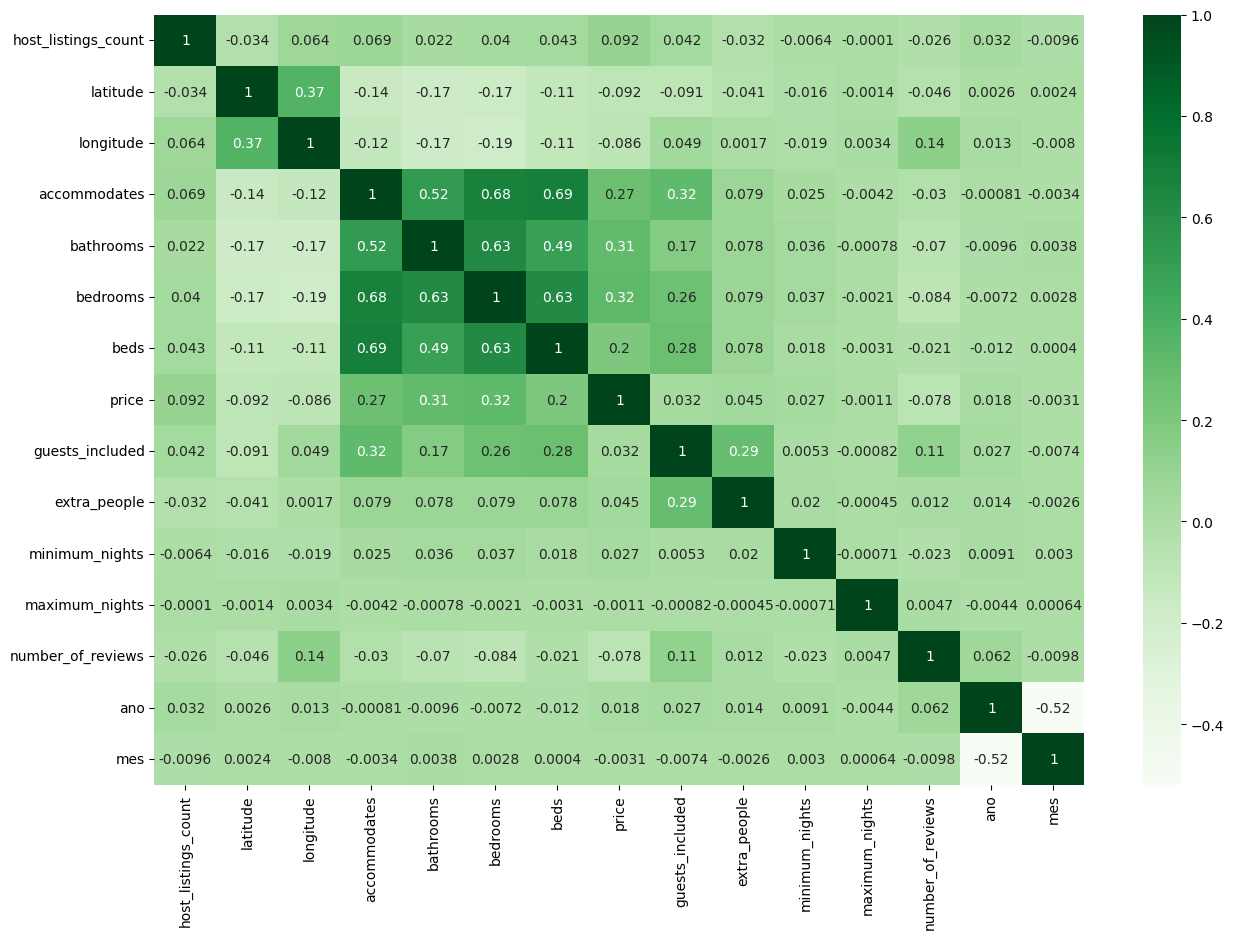

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')
#print(base_airbnb.corr(numeric_only=True))

## Definições de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas 

In [10]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

#print(limites(base_airbnb['price']))
#base_airbnb['price'].describe()

In [11]:
def diagrama_caixas(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(df, coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x=coluna, element='bars', kde=True)

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

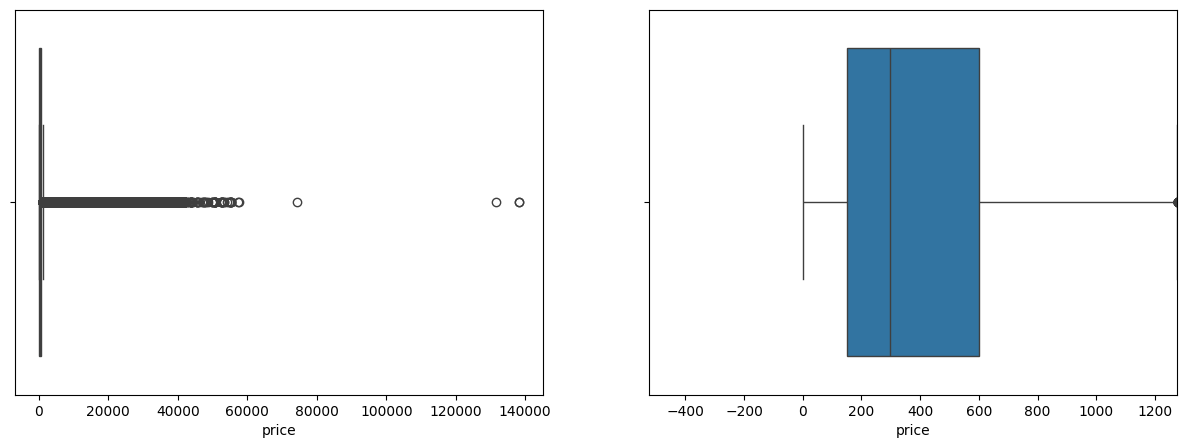

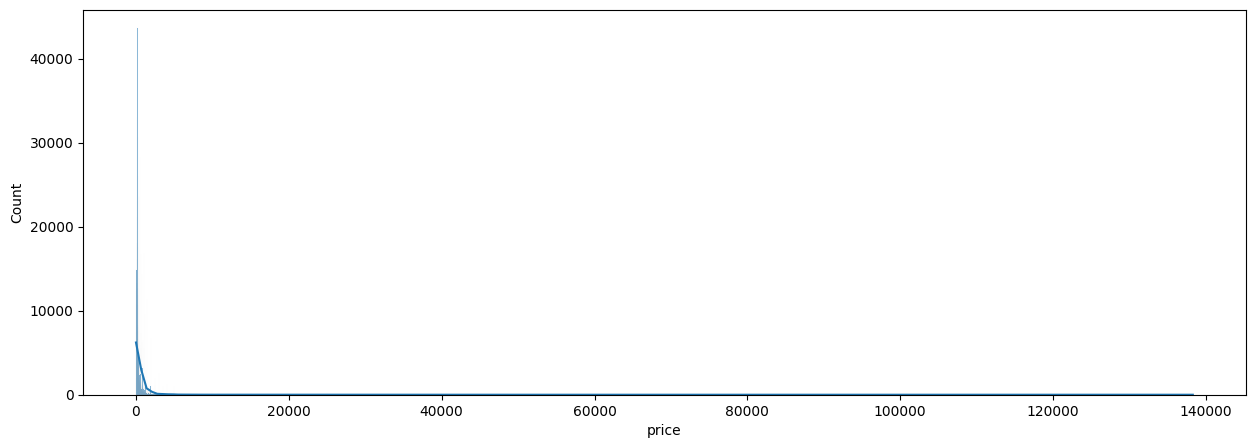

In [13]:
diagrama_caixas(base_airbnb['price'])
histograma(base_airbnb, base_airbnb['price'])

Como estamos construindo um modelo para ímoveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso principal objetivo. Por isso, podemos excluir esses outliers.

In [14]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas')

87282 linhas removidas


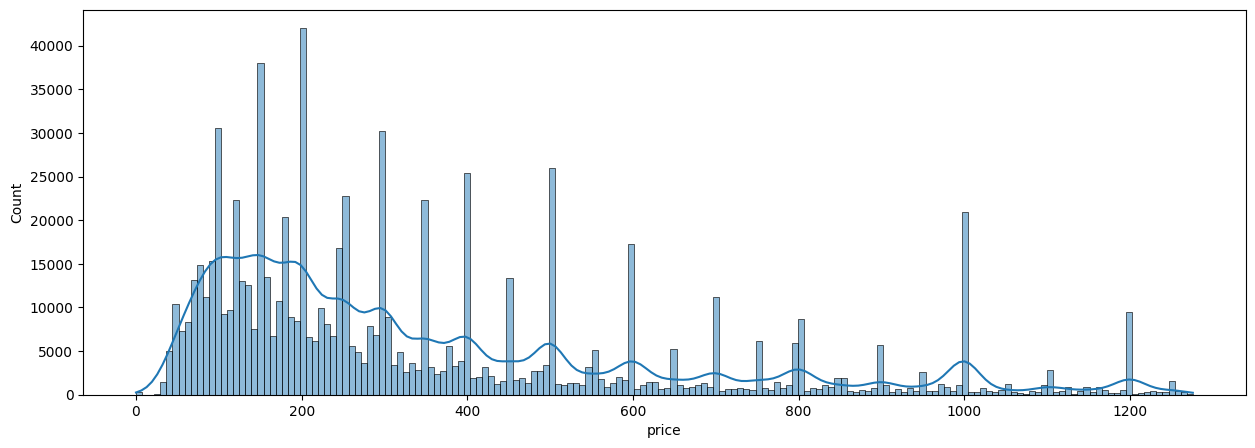

In [15]:
histograma(base_airbnb, base_airbnb['price'])

### extra_people

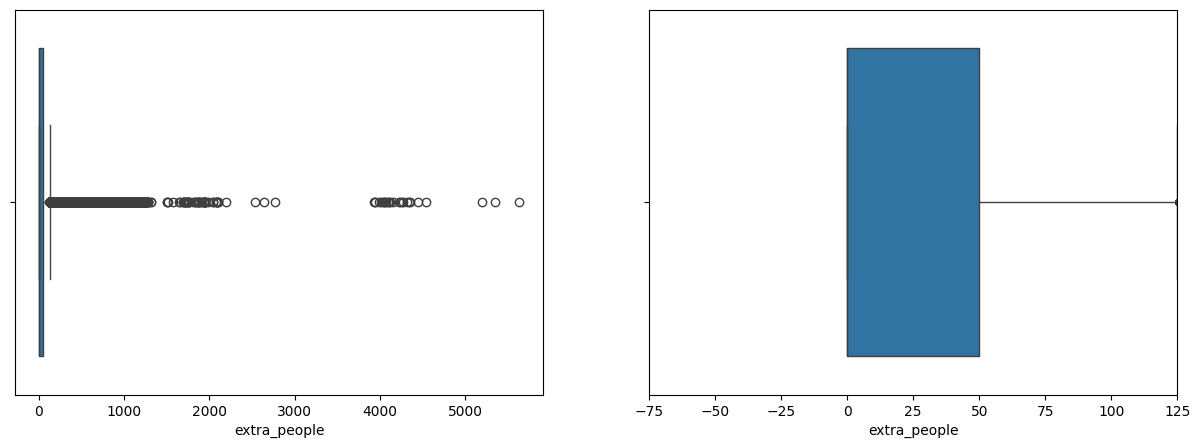

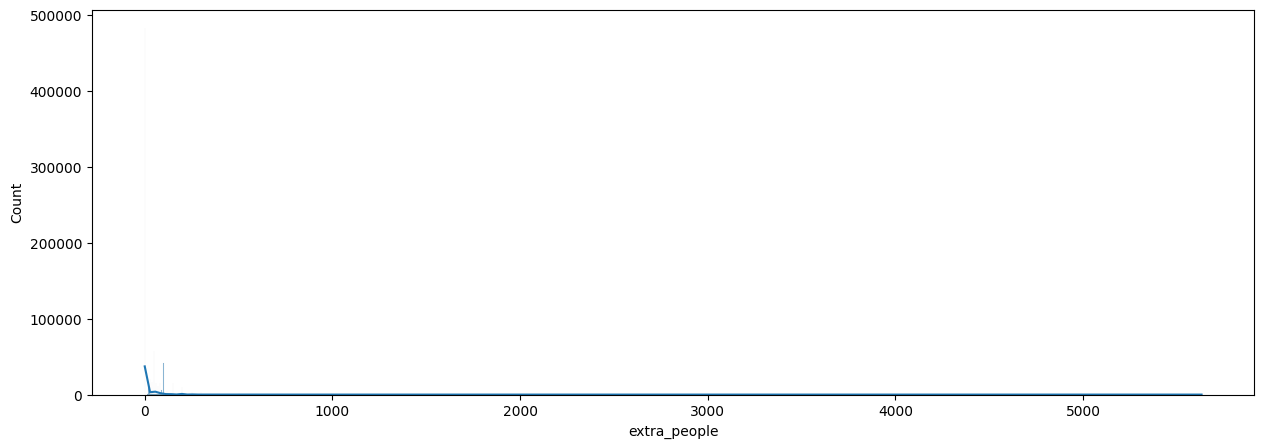

In [16]:
diagrama_caixas(base_airbnb['extra_people'])
histograma(base_airbnb, base_airbnb['extra_people'])

Irei optar por excluir os outliers, mas caso voce não queira, anote para no final você testar mantendo os outliers.

In [17]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas')

59194 linhas removidas


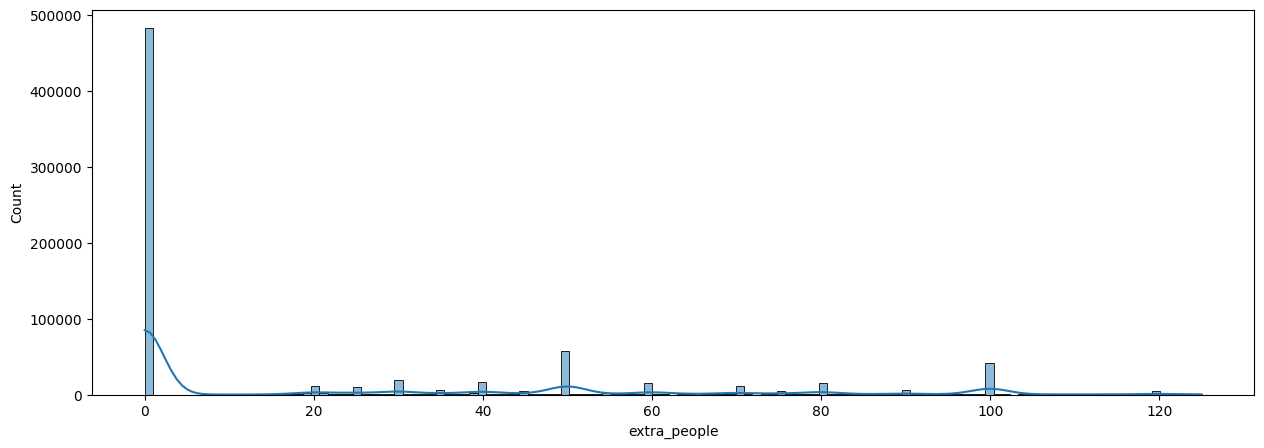

In [18]:
histograma(base_airbnb, base_airbnb['extra_people'])

### host_listings_count

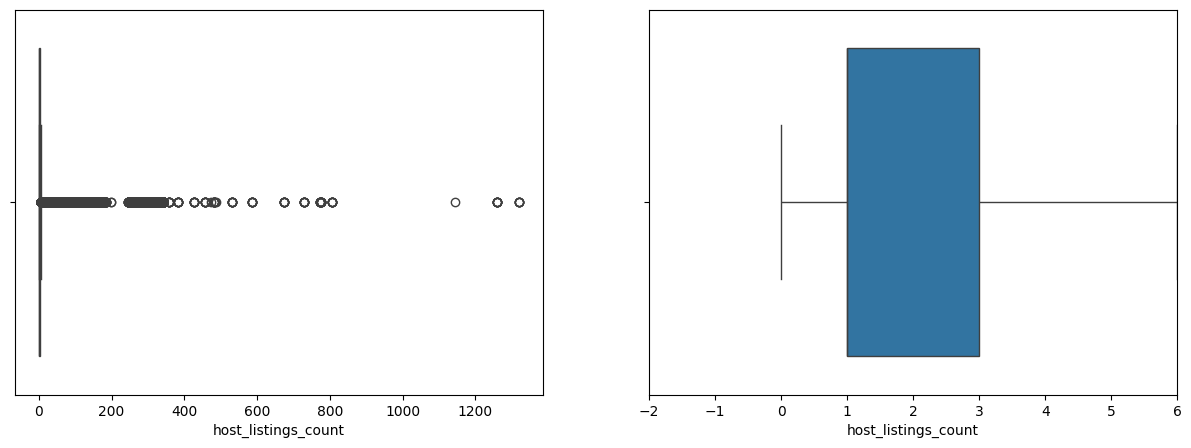

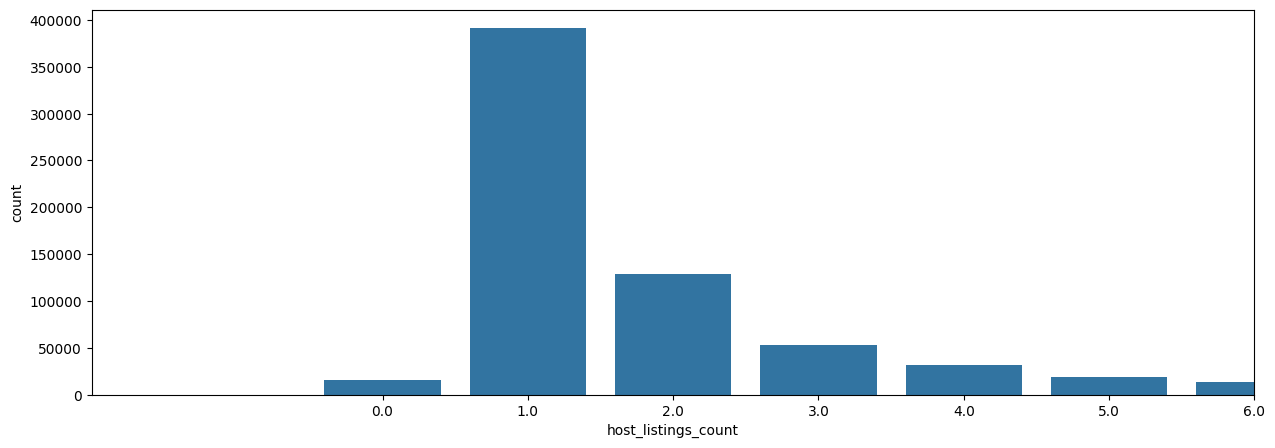

In [19]:
diagrama_caixas(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do
projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb).

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas')

97723 linhas removidas


### accommodates



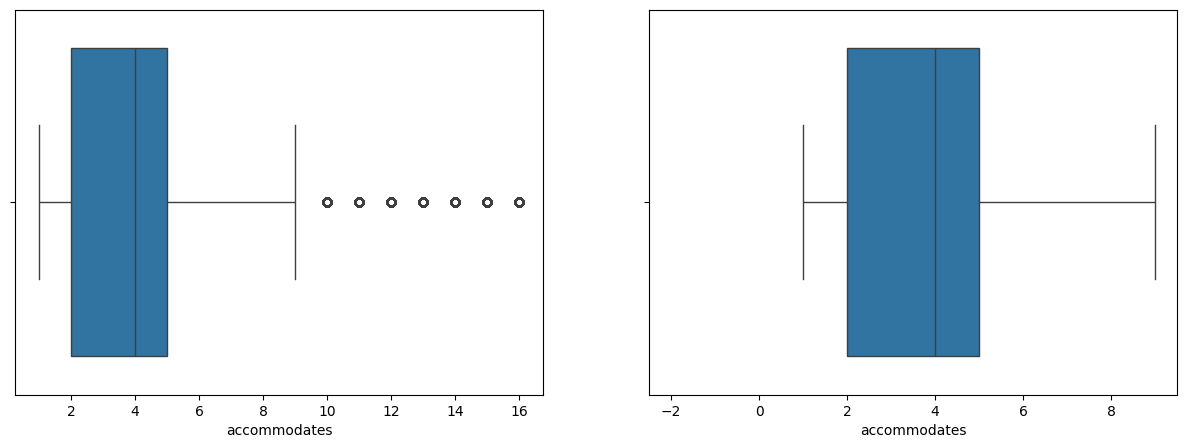

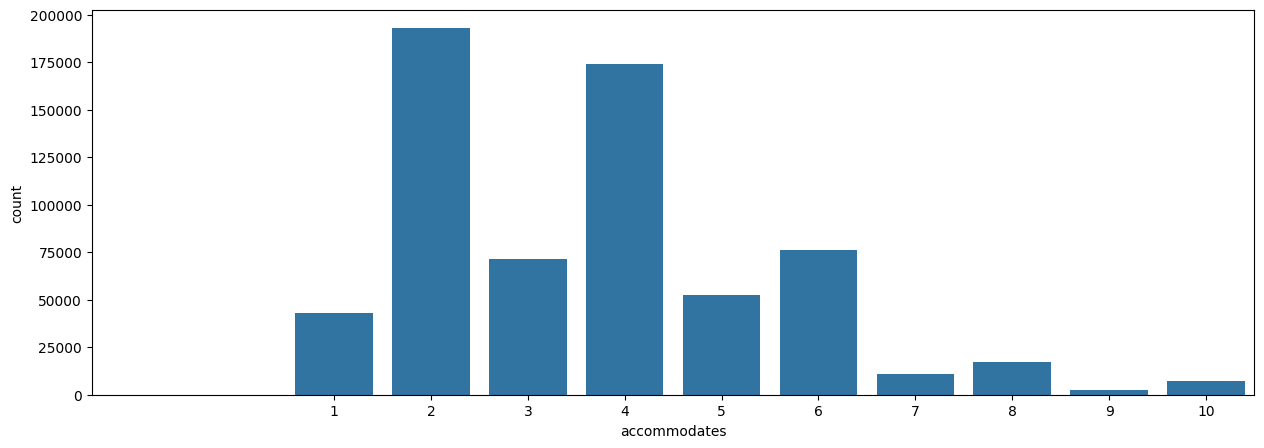

In [21]:
diagrama_caixas(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto imóveis que acomoda mais de 9 pessoas no airbnb não é o público alvo do objetivo do
projeto.

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas')

13146 linhas removidas


### bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

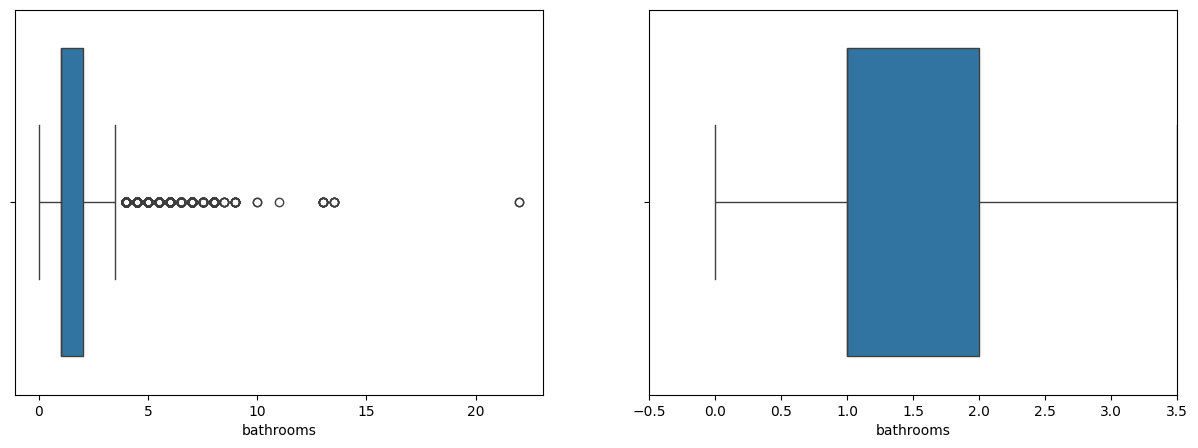

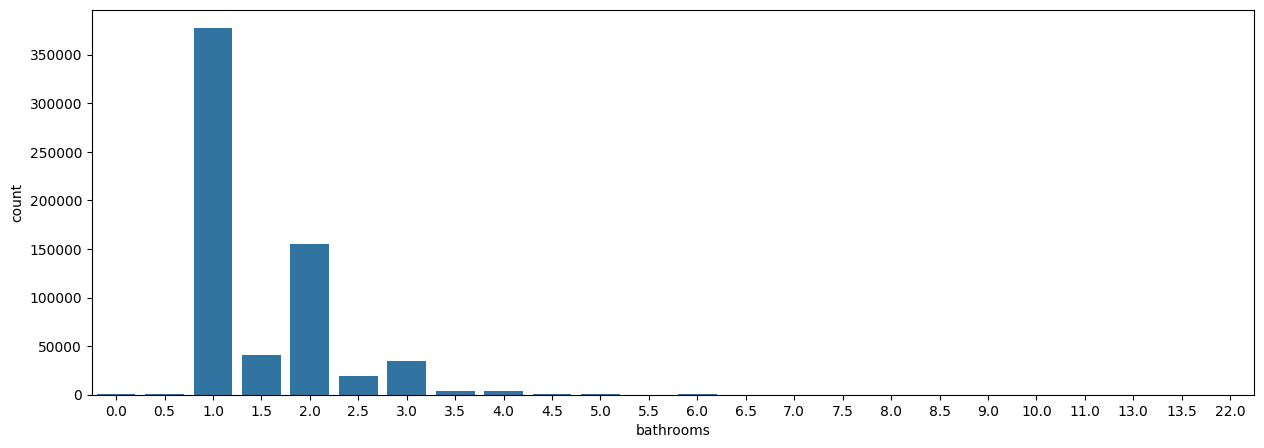

In [23]:
diagrama_caixas(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

Acima de 3,5 praticamente não vamos ter em lugar nenhum, então vou excluir os outliers.

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas')

6894 linhas removidas


### bedrooms

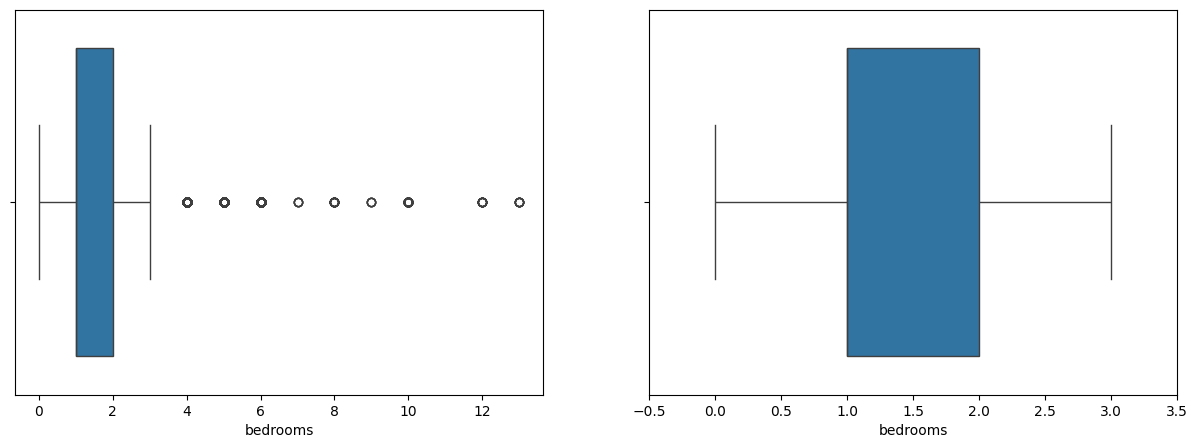

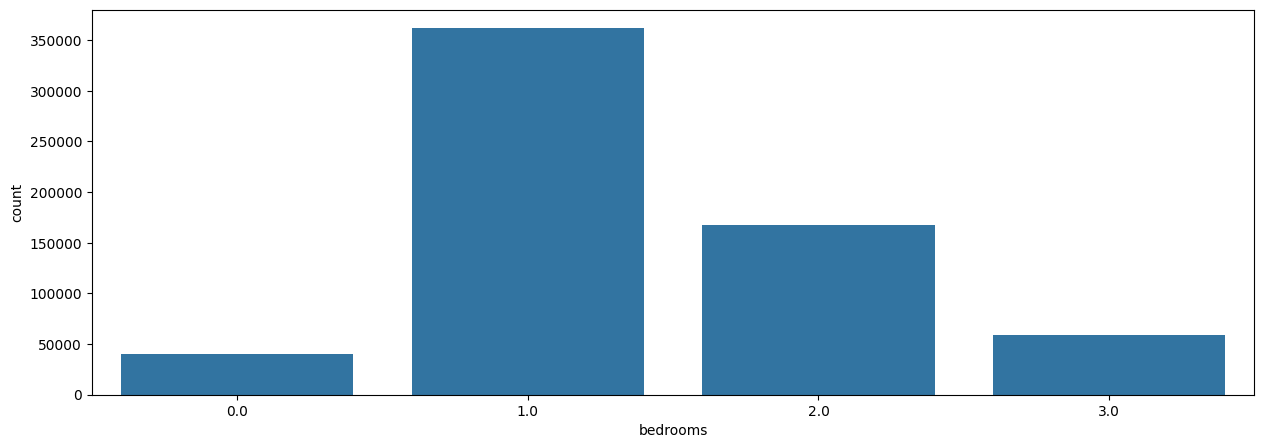

In [25]:
diagrama_caixas(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

Irei optar por excluir os outliers, mas caso voce não queira, anote para no final você testar mantendo os outliers.

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} linhas removidas')

5482 linhas removidas


### beds

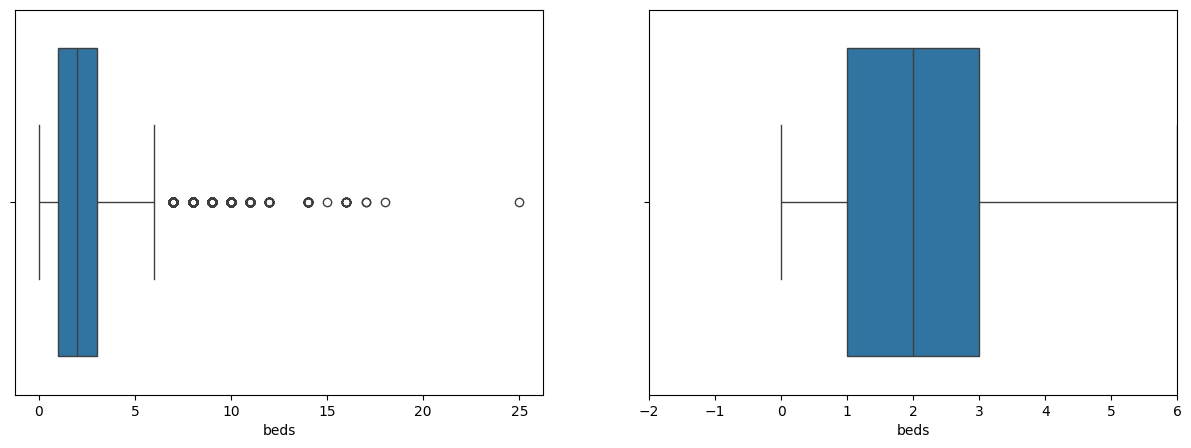

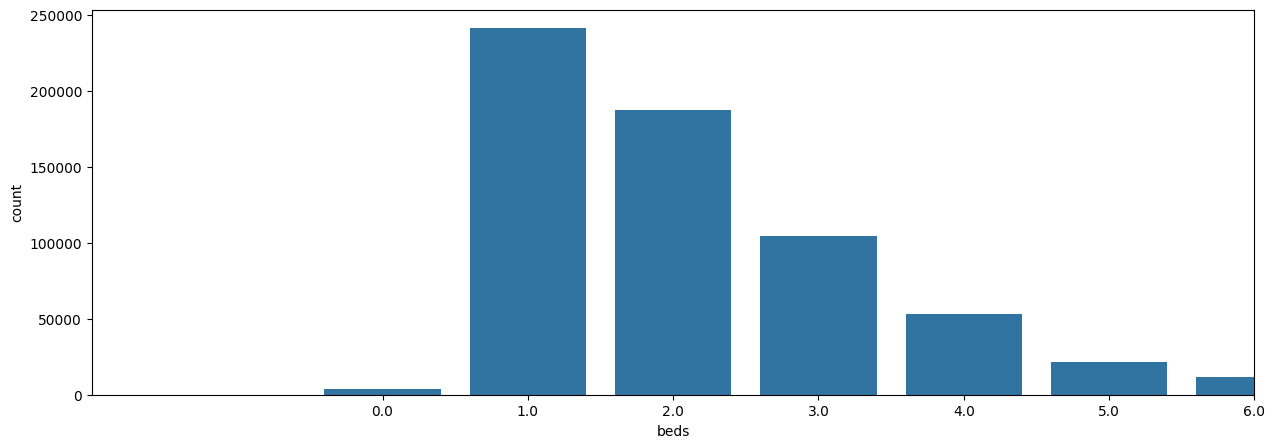

In [27]:
diagrama_caixas(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

Irei optar por excluir os outliers, mas caso voce não queira, anote para no final você testar mantendo os outliers.

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} linhas removidas')

5622 linhas removidas


### guests_included

(1.0, 1.0)


<Axes: xlabel='guests_included', ylabel='count'>

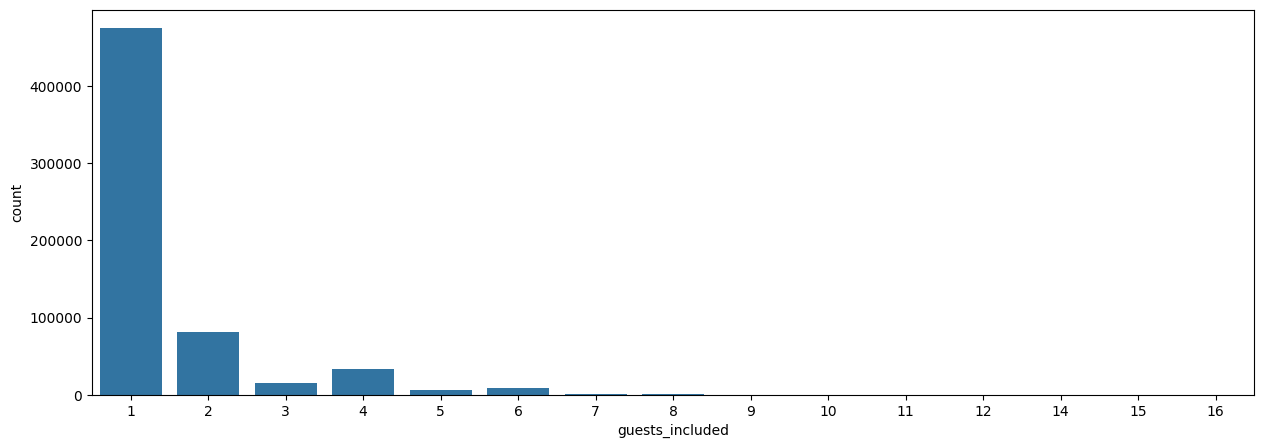

In [29]:
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o
nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [30]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

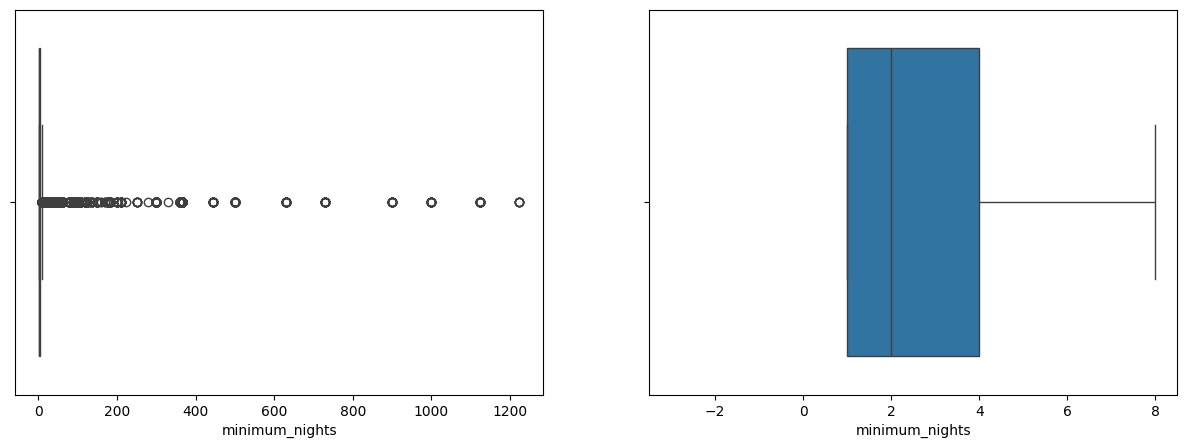

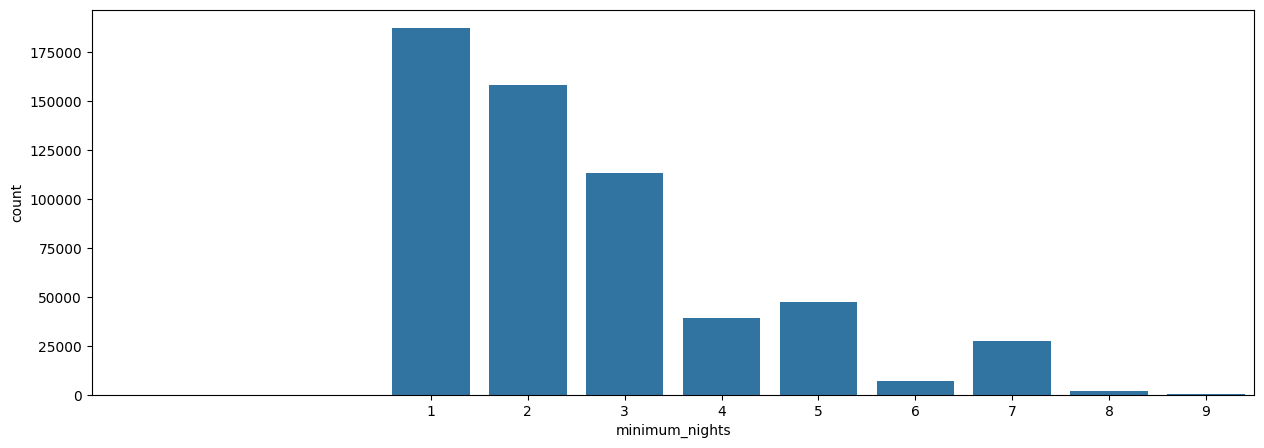

In [31]:
diagrama_caixas(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

No nosso caso, estamos pensando em alguém que tem um imóvel e ta disponibilizando esse imóvel para alugar e não aluguel de temporadas. Então não é esse o nosso objetivo, por isso irei remover os outliers.

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas')

40383 linhas removidas


### maximum_nights

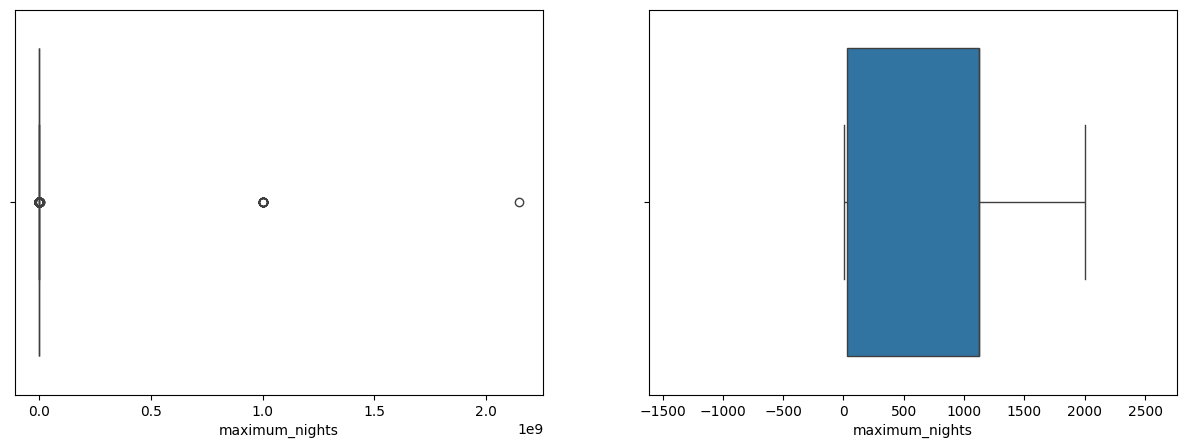

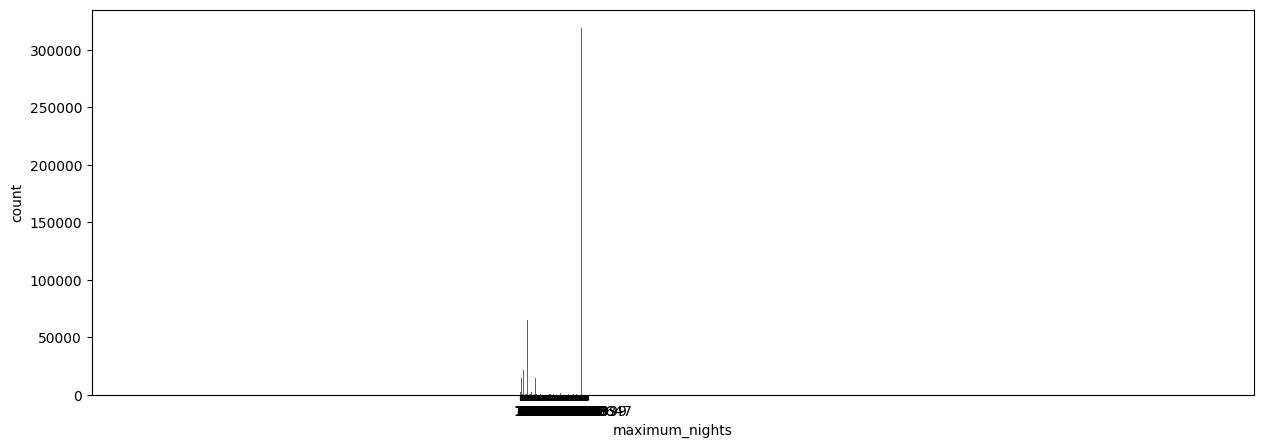

In [33]:
diagrama_caixas(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

Vamos remover essa feature da análise. Provavelmente os hosts não preecheram o máximo de noites e acabou ficando 0 como padrão e ao mesmo tempo temos alguns valores muito grandes, então quando ele pega o primeiro e terceiro quartil, ele acaba pegando esses valores muito grandes que não fazem sentido. Não será uma métrica boa para a gente então vamos excluir a coluna da análise.

In [34]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

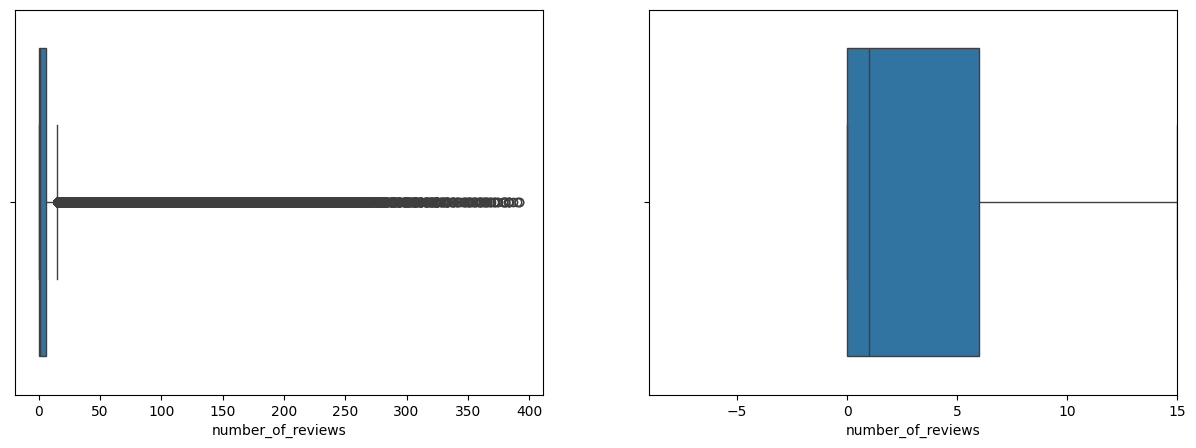

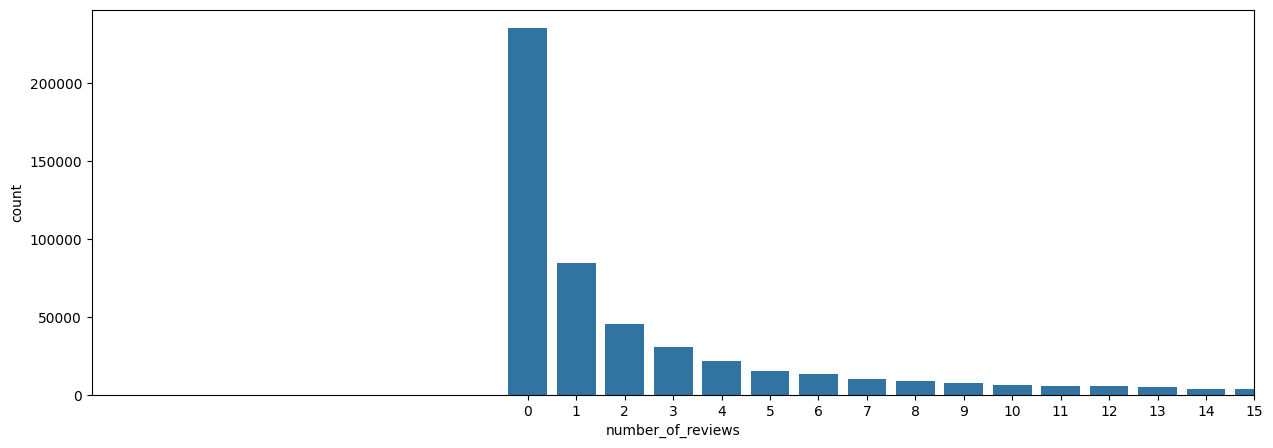

In [35]:
diagrama_caixas(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

Já que o objetivo do projeto é ajudar a precificar um imóvel que uma pessoa está querendo disponibilizar, então provavelmente a pessoa não vai ter reviews. Seguindo esse cenário, então irei optar por excluir a coluna da análise.

In [36]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

## Tratamento de Colunas de Valores de Texto

### property_type

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

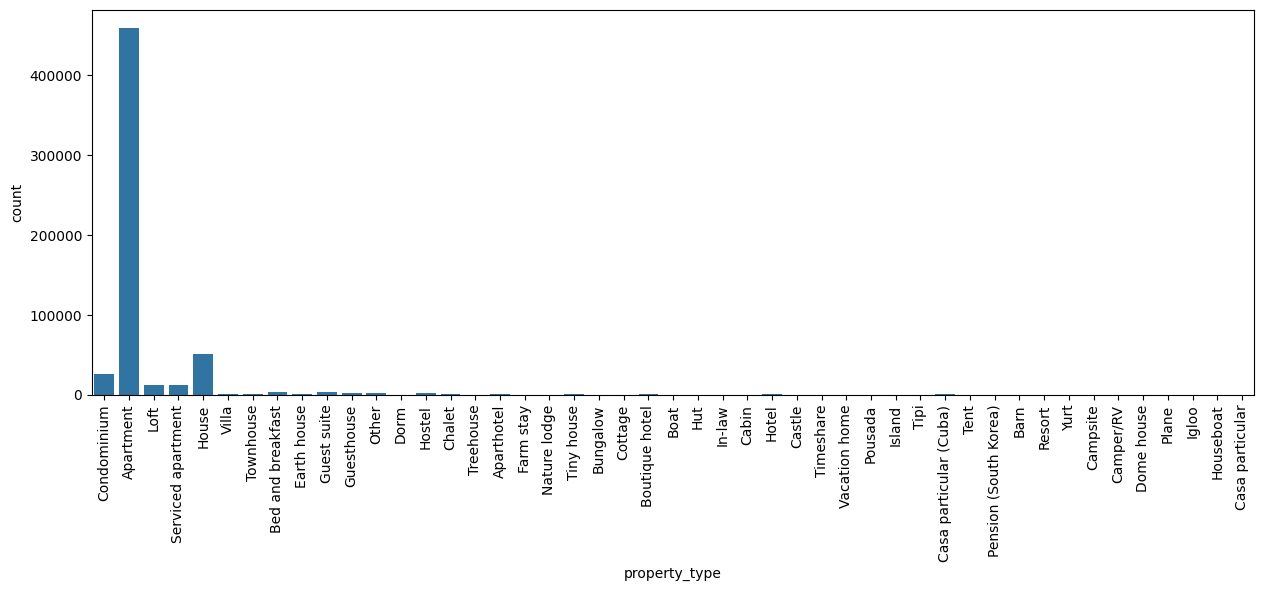

In [37]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


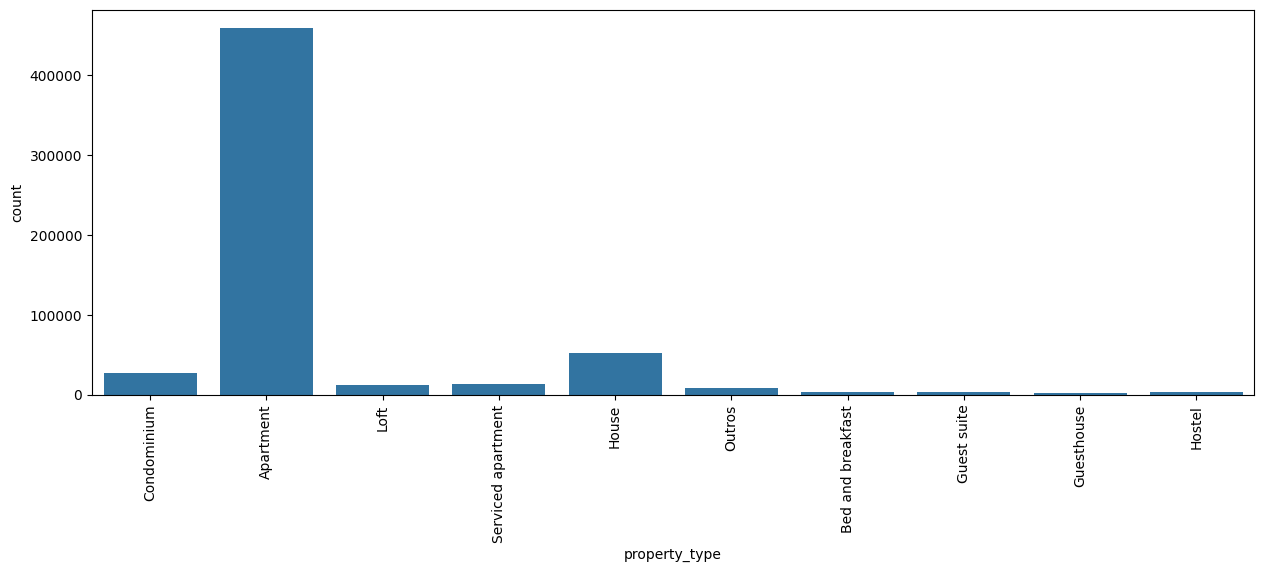

In [38]:
# agrupando categorias de property_type
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


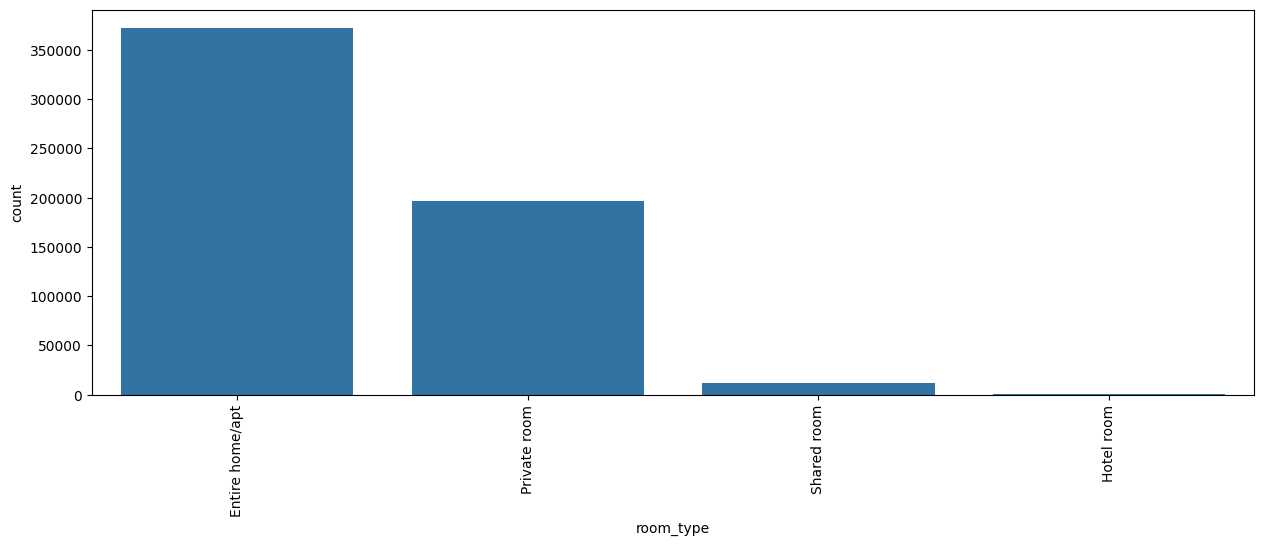

In [39]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


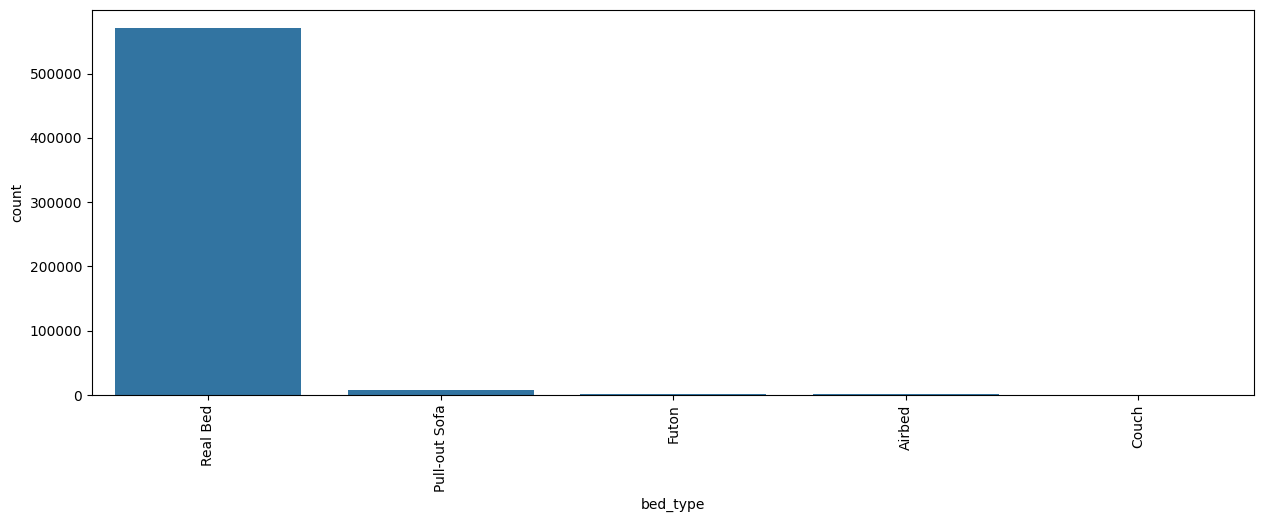

In [40]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


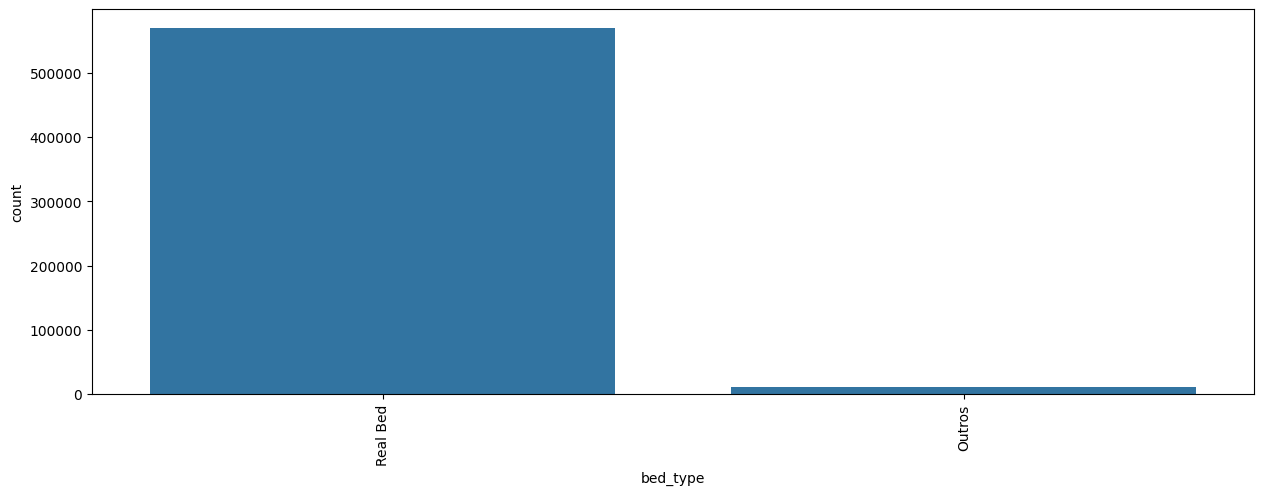

In [41]:
# agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


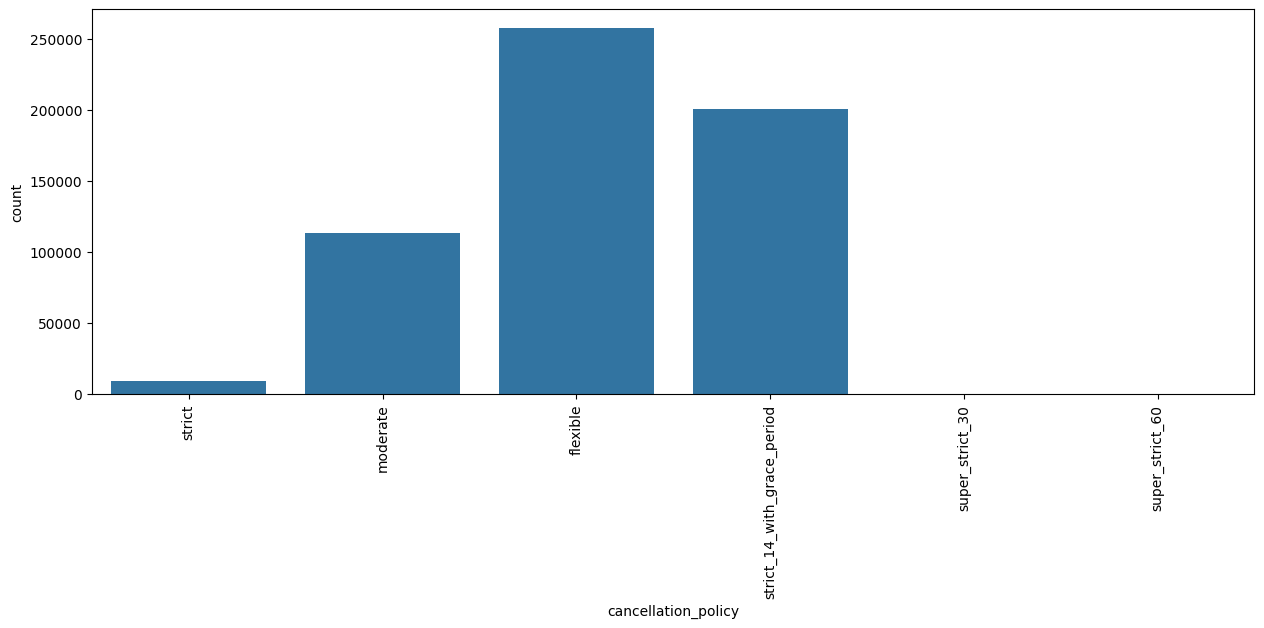

In [42]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


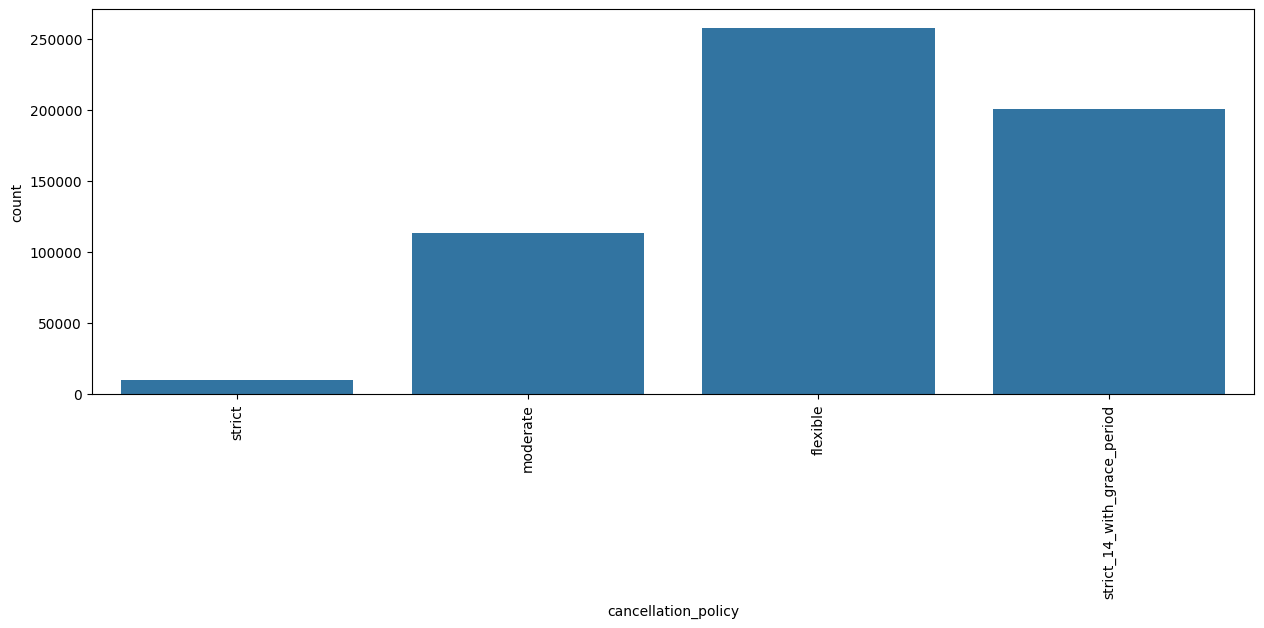

In [43]:
# agrupando categorias de cancellation_policy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)


### amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [44]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [45]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

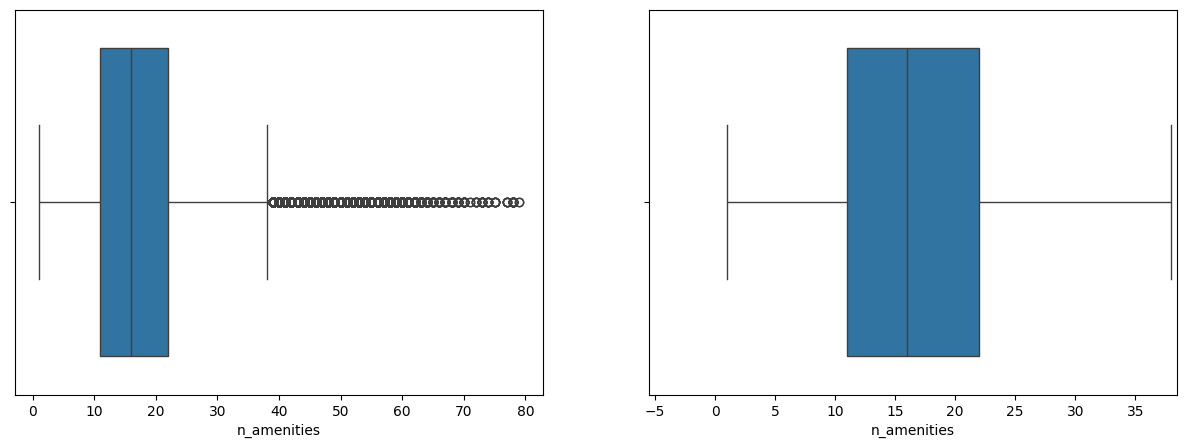

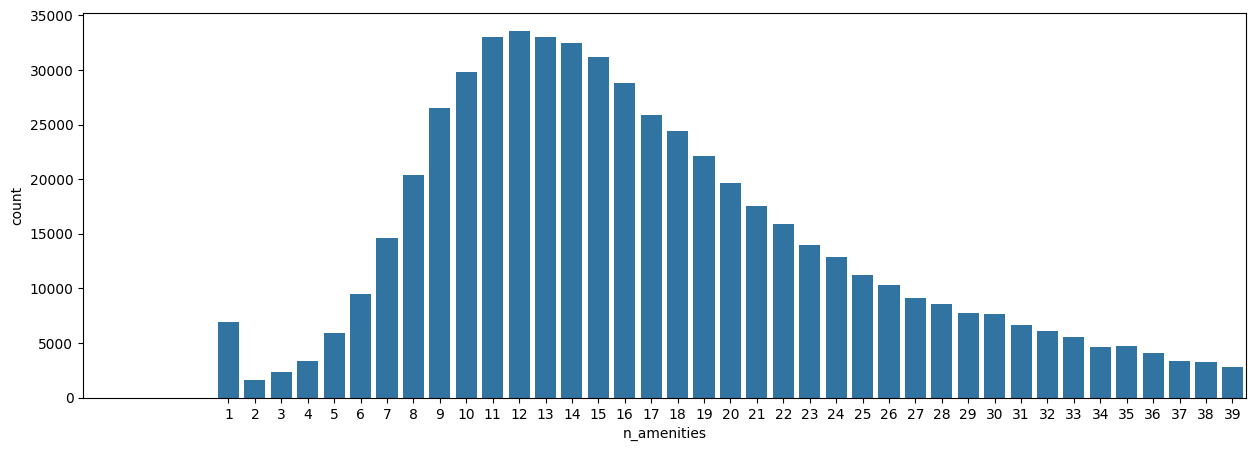

In [46]:
diagrama_caixas(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [47]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'{linhas_removidas} linhas removidas')

24343 linhas removidas


## Visualização de Mapas das Propriedades

In [48]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='open-street-map')
mapa.show()

## Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies.

In [49]:
# substituindo colunas de true e false por 1 e 0 
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

base_airbnb_cod.iloc[0]

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object

In [50]:
# utilizando o método de enconding de variáveis dummies nas features de coluna
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias, dtype=int)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

## Modelo de Previsão

- Métricas de avaliação

In [51]:
# Definição de Métricas para Avaliação e Comparação dos Modelos
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo: {nome_modelo}\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

- Escolha dos modelos a serem testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [52]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et,
           }

y = base_airbnb_cod['price'] # valor que quero calcular (preço)
X = base_airbnb_cod.drop('price', axis=1) # features

- Separação dos dados entre treino e teste + Treino do modelo

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test) # caracteristicas dos dados de teste
    print(avaliar_modelo(nome_modelo, y_test, previsao)) # esse modelo vai comparar os valores de y que ele está prevendo com os valores de y corretos

Modelo: RandomForest
R²: 97.25%
RSME: 43.95
Modelo: LinearRegression
R²: 32.70%
RSME: 217.54
Modelo: ExtraTrees
R²: 97.50%
RSME: 41.95


## Análise do Melhor Modelo

- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliação no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²: 97.50%<br>
RSME: 41.95

## Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.118487
latitude                                         0.104046
longitude                                        0.101140
n_amenities                                      0.089498
extra_people                                     0.085631
bathrooms                                        0.071903
accommodates                                     0.067576
room_type_Entire home/apt                        0.065042
minimum_nights                                   0.064653
beds                                             0.053103
host_listings_count                              0.039853
instant_bookable                                 0.021998
cancellation_policy_flexible                     0.019124
host_is_superhost                                0.013579
property_type_Apartment                          0.012774
cancellation_policy_moderate                     0.012320
ano                                              0.011317
cancellation_policy_strict_14_with_grace_period  0.007871
property_type_House                              0.007098
property_type_Condominium                        0.005172
mes                                              0.004692
room_type_Private room                           0.004346
bed_type_Real Bed                                0.002728
bed_type_Outros                                  0.002660
property_type_Outros                             0.002363
property_type_Serviced apartment                 0.002224
property_type_Loft                               0.002184
room_type_Shared room                            0.001901
property_type_Bed and breakfast                  0.001295
property_type_Guesthouse                         0.000935
cancellation_policy_strict                       0.000864
property_type_Guest suite                        0.000679
property_type_Hostel                             0.000634
room_type_Hotel room                             0.000311
is_business_travel_ready                         0.000000

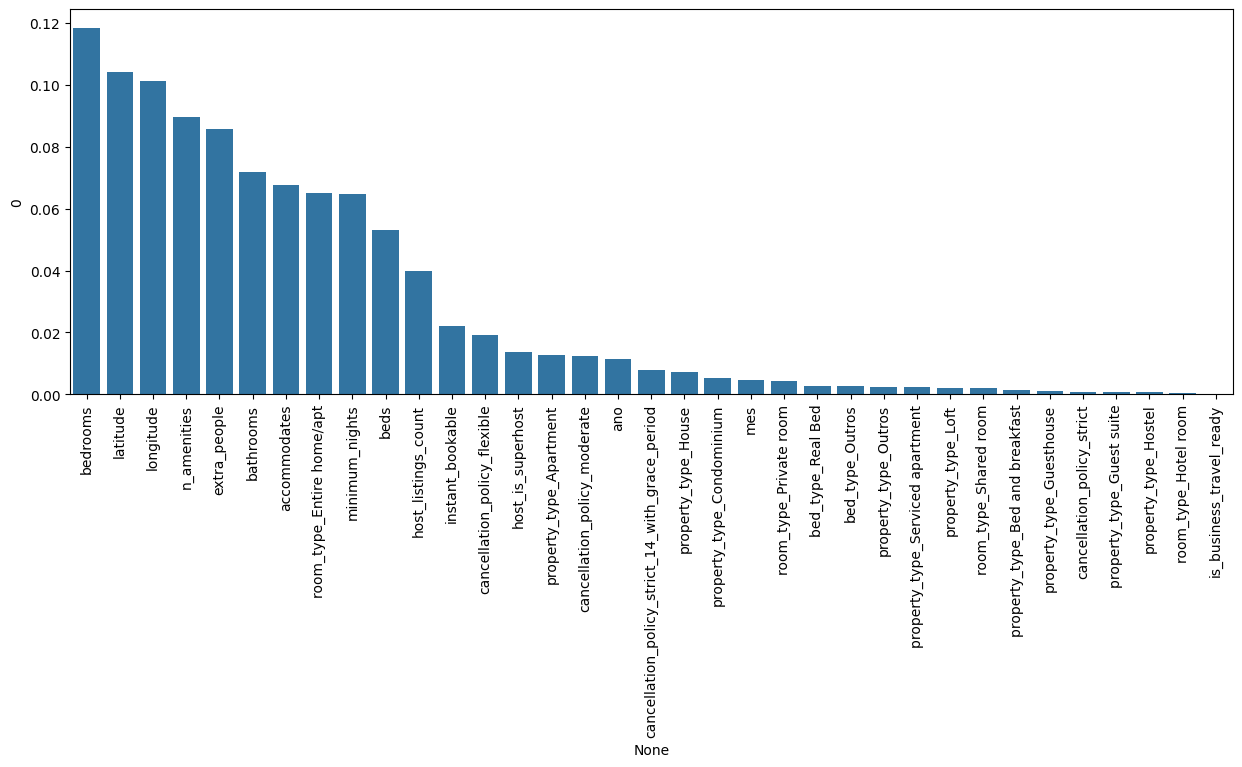

In [54]:
# print(modelo_et.feature_importances_)
# print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

- Chegamos a conclusão que a localização e número de quartos parece ser crucial para definir o preço, o que faz bastante sentido.

## Ajustes Finais no Modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [55]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao)) 

Modelo: ExtraTrees
R²: 97.50%
RSME: 41.93


- As colunas de room_type não me parecem ter um impacto muito grande pela posição deles no gráfico, estão irei fazer um teste removendo essas colunas.

In [56]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo: ExtraTrees
R²: 97.51%
RSME: 41.88


- Impactou pouco no resultado e tornou o modelo mais simples (1 feature a menos para fazer a análise), então talvez esse modelo seja melhor do que um modelo que tenha o tipo de cama.

## Deploy do Projeto

Iremos seguir o seguinte passo a passo para fazer o deploy do nosso projeto:

- Passo 1: Criar arquivo do Modelo (joblib)<br>
- Passo 2: Escolher a forma de deploy (iremos usar o Streamlit)
- Passo 3: Outro arquivo Python
- Passo 4: Importar streamlit e criar código
- Passo 5: Atribuir ao botão o carregamento do modelo
- Passo 6: Deploy feito

In [57]:
# colocando a coluna de preço de novo dentro da variável X e depois salvando como arquivo csv
X['price'] = y
X.to_csv('dados.csv')

In [58]:
# tranformando o modelo_et (um objeto python) em um arquivo, aí qualquer outro código python pode usar o joblib para ler esse arquivo de novo
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']